# Figures

In this notebook, I collect the codes that are used for making figures. This is prepared to fulfill the data availability requirements.

## 0 Packages

In [2]:
from skimage import io, draw
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imutils import rotate
from matplotlib.patches import Rectangle
from myimagelib.myImageLib import readdata, bestcolor, show_progress, to8bit
import os
from myimagelib.pivLib import PIV, PIV_masked, read_piv, to_matrix, apply_mask, compact_PIV
from IPython.display import clear_output
from myimagelib.corrLib import divide_windows, corrS
from tifffile import imwrite
from nd2reader import ND2Reader
from scipy.io import loadmat
from scipy.ndimage import uniform_filter1d, gaussian_filter1d, map_coordinates
import matplotlib
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
plt.rcParams['xtick.major.size'] = 2  # Length of major ticks
plt.rcParams['ytick.major.size'] = 2  # Length of major ticks
plt.rcParams['xtick.minor.size'] = 1  # Length of minor ticks
plt.rcParams['ytick.minor.size'] = 1  # Length of minor ticks

## Figure 2

In [6]:
base = r"E:\AN\SYMMETRIC\15 dec 2022"
folder = os.path.join(base, "Flow_rate")
l = readdata(folder, "csv")
window_size = 50
list(l.Name)

['00', '01', '02', '03']

C:\Users\zl948\AppData\Local\Temp\ipykernel_116796\884673480.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  video_colors = plt.cm.get_cmap("winter", len(files))


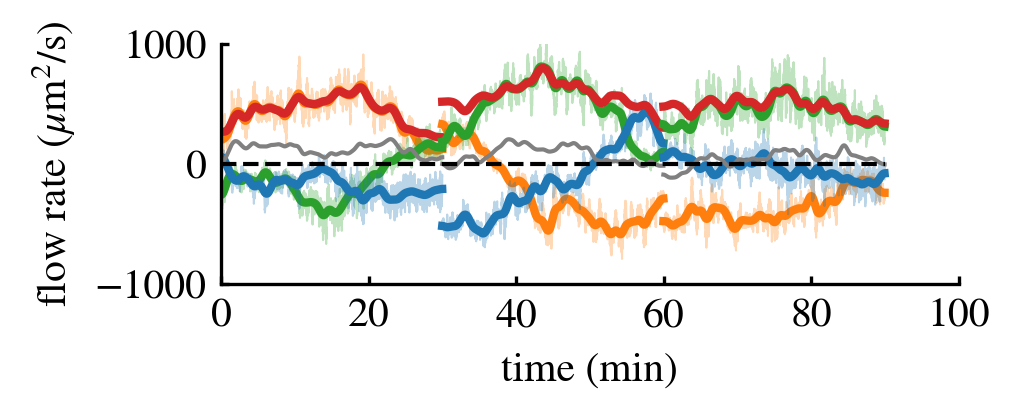

In [7]:
files = ["{:02d}.csv".format(i) for i in range(0,3)]

colors = {"A": bestcolor(0), "B": bestcolor(1), "C": bestcolor(2), "normalizer": bestcolor(3)}
video_colors = plt.cm.get_cmap("winter", len(files))

plt.figure(figsize=(3.5, 1.5), dpi=300)
offset = 0
for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file)).dropna()
    flowrate["normalizer"] = gaussian_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), sigma=window_size, axis=0)
    flowrate_smooth = gaussian_filter1d(flowrate[["A", "B", "C"]], sigma=50, axis=0)
    flowrate.t /= 60
    # flowrate = replace_outlier(flowrate)
    if num == 0:        
        for i, channel_name in enumerate(flowrate.drop(columns=["t"])):        
            plt.plot(flowrate.t + offset, flowrate[channel_name], color=colors[channel_name], alpha=0.3, lw=0.5)
            plt.plot(flowrate.t + offset, gaussian_filter1d(flowrate[channel_name], sigma=50), color=colors[channel_name], lw=2, label=channel_name)
        plt.plot(flowrate.t + offset, flowrate_smooth.sum(axis=1), color="gray", label="A+B+C", lw=1)
    else:
        for i, channel_name in enumerate(flowrate.drop(columns=["t"])):  
            plt.plot(flowrate.t + offset, flowrate[channel_name], color=colors[channel_name], alpha=0.3, lw=0.5)
            plt.plot(flowrate.t + offset, gaussian_filter1d(flowrate[channel_name], sigma=50), color=colors[channel_name], lw=2)
        plt.plot(flowrate.t + offset, flowrate_smooth.sum(axis=1), color="gray", lw=1)
    
    # video indicator
    offset0 = offset
    offset += flowrate["t"].max()
#     y = flowrate.drop(columns=["t"]).min().min()
#     plt.plot([offset0, offset], [y, y], color=video_colors(num))
#     plt.annotate("{}".format(os.path.splitext(file)[0]), ((offset0+offset)/2, y), xycoords="data", 
#                 horizontalalignment="center", verticalalignment="top")
# # plt.grid(True, ls="--")
plt.plot([0, offset], [0, 0], ls="--", lw=1, color="black")
# plt.legend(ncol=3, frameon=False, fontsize=8)
plt.xlabel("time (min)")
plt.ylabel("flow rate ($\mu$m$^2$/s)")
plt.yticks([-1000, 0, 1000])
plt.ylim([-1000, 1000])
plt.xlim([0, 100])
# upper axis line off
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(r"symmetric.pdf")

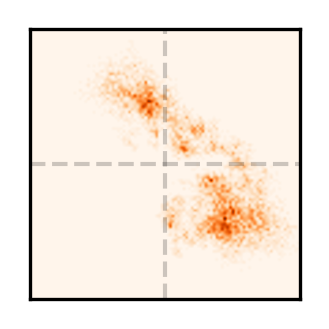

In [8]:
fr_list = []

for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file)).dropna()
    flowrate["normalizer"] = gaussian_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), sigma=window_size, axis=0)
    fr_list.append(flowrate)
combined = pd.concat(fr_list)

fig, ax = plt.subplots(figsize=(1.2, 1.2), dpi=300)
lim = 1000

H, xedges, yedges = np.histogram2d(combined["B"], combined["C"], bins=(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100)))
ax.imshow(H, interpolation='spline16', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
ax.plot([-lim, lim], [0, 0], ls="--", lw=1, color="black", alpha=0.2)
ax.plot([0, 0], [-lim, lim], ls="--", lw=1, color="black", alpha=0.2)
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
# ax.set_xlabel("C")
# ax.set_ylabel("B")
# hide ticks
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig("symmetric_histogram.pdf")

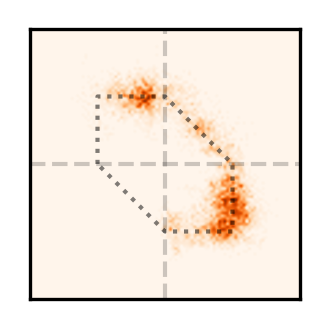

In [9]:
fr_list = []

for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file)).dropna()
    flowrate["normalizer"] = gaussian_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), sigma=window_size, axis=0)
    fr_list.append(flowrate)
combined = pd.concat(fr_list)

fig, ax = plt.subplots(figsize=(1.2, 1.2), dpi=300)
lim = 2

H, xedges, yedges = np.histogram2d(combined["B"]/combined["normalizer"], combined["C"]/combined["normalizer"], bins=(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100)))
ax.imshow(H, interpolation='spline16', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
ax.plot([-lim, lim], [0, 0], ls="--", lw=1, color="black", alpha=0.2)
ax.plot([0, 0], [-lim, lim], ls="--", lw=1, color="black", alpha=0.2)
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
# ax.set_xlabel("C")
# ax.set_ylabel("B")
# hide ticks
ax.set_xticks([])
ax.set_yticks([])
# draw mass conservation line
x = [-1, -1, 0, 1, 1, 0, -1]
y = [0, 1, 1, 0, -1, -1, 0]
plt.plot(x, y, lw=1, color="black", alpha=0.5, ls=":")
plt.tight_layout()
plt.savefig("symmetric_histogram_normalized.pdf")

In [10]:
def flow_potential(phi, type="v6"):
    """Flow potential of edge flow. Double well.
    phi -- flow rate
    type -- v6 or v4, denoting two plausible models."""
    if type == "v6":
        return - 1 / 4 * phi ** 4 + 1/6 * phi**6
    elif type == "v4":
        return - 1 / 2 * phi ** 2 + 1/4 * phi**4

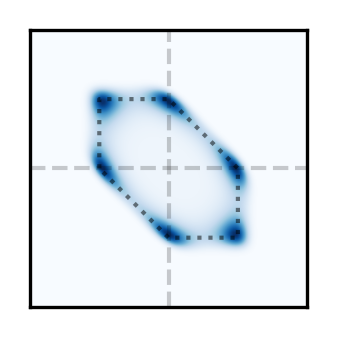

In [11]:
lim = 2
num_points = 100
phi1 = np.linspace(-lim, lim, num_points)
phi2 = np.linspace(-lim, lim, num_points)
# phi3 = np.linspace(-lim, lim)
D = np.array([-1, -1, -1])
a = 30# lambda
b = 2 # mu
H = np.zeros((len(phi1), len(phi2)))

fig, ax = plt.subplots(figsize=(1.2, 1.2), dpi=300)
for i, p1 in enumerate(phi1):
    for j, p2 in enumerate(phi2):
        p3 = - p1 - p2
        H[i, j] = a * (flow_potential(p1, type="v6") + flow_potential(p2, type="v6") + flow_potential(p3, type="v6")) + 1/2 * b * np.sum((D * np.array([p1, p2, p3]))**2) 
ax.imshow(np.exp(-H), origin="lower", extent=(-lim, lim, -lim, lim), cmap="Blues", interpolation="spline16")
ax.plot([-lim, lim], [0, 0], ls="--", lw=1, color="black", alpha=0.2)
ax.plot([0, 0], [-lim, lim], ls="--", lw=1, color="black", alpha=0.2)
ax.set_xticks([-1, 1])
ax.set_yticks([-1, 1])
ax.set_xticks([-2, 0, 2])
ax.set_yticks([-2, 0, 2])
# ax.set_xlabel("$\phi_2$")
# ax.set_ylabel("$\phi_1$")
ax.set_xticks([])
ax.set_yticks([])
# draw mass conservation line
x = [-1, -1, 0, 1, 1, 0, -1]
y = [0, 1, 1, 0, -1, -1, 0]
plt.plot(x, y, lw=1, color="black", alpha=0.5, ls=":")
fig.savefig("theo_prob_01.pdf")

## Figure 3

In [12]:
main_folder = "E:\AN\ASYMMETRIC"
dates = ["22_january_2022", "10_july_2022_E1", "10_july_2022_E2", "20_july_2022", "28_december_2022"]
window_size = 50
l_list = []
for date in dates:
    folder = os.path.join(main_folder, date, "Flow_rate")
    l_list.append(readdata(folder, "csv"))
l = pd.concat(l_list)
list(l.Name)

['00',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '00',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '00',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '00',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '00',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07']

In [21]:
dates = ["22_january_2022", "10_july_2022_E1", "10_july_2022_E2", "20_july_2022", "28_december_2022"]
main_folder = "E:\AN\ASYMMETRIC"

In [ ]:
# some statistics
window_size = 50
for date in dates:
    folder = os.path.join(main_folder, date, "Flow_rate")
    l = readdata(folder, "csv")
    total = 0
    fr_list = []
    for num, i in l.iterrows():
        flowrate = pd.read_csv(i.Dir).dropna()
        flowrate["normalizer"] = uniform_filter1d(flowrate[flowrate.columns.drop("t")].abs().max(axis=1), size=window_size, axis=0)
        total += len(flowrate)
        fr_list.append(flowrate)
    combined = pd.concat(fr_list)
    nominal_flowrate = combined["normalizer"].mean()
    print("{0:18}: {1:2d} videos, {2:5d} points, {3:7.2f} um^2/s".format(date, num+1, total, nominal_flowrate))

C:\Users\zl948\AppData\Local\Temp\ipykernel_116796\2748475470.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  video_colors = plt.cm.get_cmap("winter", len(files))


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\AN\\ASYMMETRIC\\28_december_2022\\Flow_rate\\08.csv'

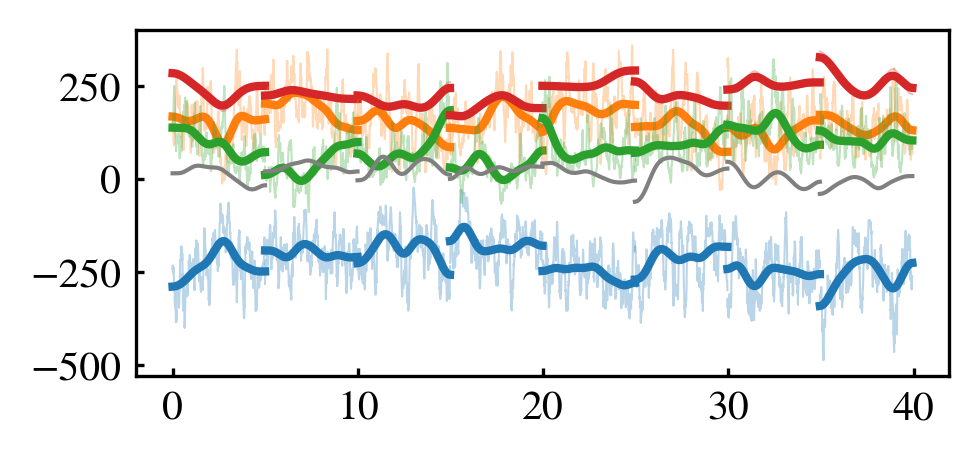

In [19]:
files = ["{:02d}.csv".format(int(i.Name)) for num, i in l.iterrows()]

colors = {"A": bestcolor(0), "B": bestcolor(1), "C": bestcolor(2), "normalizer": bestcolor(3)}
video_colors = plt.cm.get_cmap("winter", len(files))

plt.figure(figsize=(3.5, 1.5), dpi=300)
offset = 0
for num, i in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file)).dropna()
    flowrate["normalizer"] = gaussian_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), sigma=window_size, axis=0)
    flowrate_smooth = gaussian_filter1d(flowrate[["A", "B", "C"]], sigma=50, axis=0)
    flowrate.t /= 60
    # flowrate = replace_outlier(flowrate)
    if num == 0:        
        for i, channel_name in enumerate(flowrate.drop(columns=["t"])):        
            plt.plot(flowrate.t + offset, flowrate[channel_name], color=colors[channel_name], alpha=0.3, lw=0.5)
            plt.plot(flowrate.t + offset, gaussian_filter1d(flowrate[channel_name], sigma=50), color=colors[channel_name], lw=2, label=channel_name)
        plt.plot(flowrate.t + offset, flowrate_smooth.sum(axis=1), color="gray", label="A+B+C", lw=1)
    else:
        for i, channel_name in enumerate(flowrate.drop(columns=["t"])):  
            plt.plot(flowrate.t + offset, flowrate[channel_name], color=colors[channel_name], alpha=0.3, lw=0.5)
            plt.plot(flowrate.t + offset, gaussian_filter1d(flowrate[channel_name], sigma=50), color=colors[channel_name], lw=2)
        plt.plot(flowrate.t + offset, flowrate_smooth.sum(axis=1), color="gray", lw=1)
    
    # video indicator
    offset0 = offset
    offset += flowrate["t"].max()
#     y = flowrate.drop(columns=["t"]).min().min()
#     plt.plot([offset0, offset], [y, y], color=video_colors(num))
#     plt.annotate("{}".format(os.path.splitext(file)[0]), ((offset0+offset)/2, y), xycoords="data", 
#                 horizontalalignment="center", verticalalignment="top")
# # plt.grid(True, ls="--")
plt.plot([0, offset], [0, 0], ls="--", lw=1, color="black")
# plt.legend(ncol=3, frameon=False, fontsize=8)
plt.xlabel("time (min)")
plt.ylabel("flow rate ($\mu$m$^2$/s)")
plt.yticks([-1000, 0, 1000])
# plt.ylim([-1000, 1000])
plt.xlim([0, 100])
# upper axis line off
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(r"symmetric.pdf")

In [15]:
flowrate

,A,B,C,t,normalizer
0,-243.514930,232.655623,94.708976,0.000000,228.926863
1,-221.688840,207.137230,87.780940,0.008333,228.921274
2,-216.499722,198.750590,85.865873,0.016667,228.909998
3,-212.614122,185.905630,75.048099,0.025000,228.892968
4,-188.748504,133.761769,80.554433,0.033333,228.870320
...,...,...,...,...,...
595,-323.056649,146.013755,166.052944,4.958333,259.726986
596,-309.227475,148.360419,177.054681,4.966667,259.797212
597,-299.803968,116.756748,191.946888,4.975000,259.849868
598,-248.059754,81.456716,180.270344,4.983333,259.884998


In [16]:
offset

14.974999999999998